In [1]:
import pandas as pd
import numpy as np
import pickle
import os
os.chdir('/home/lichi/jupiter/imaginarium')

from random import sample
from PIL import Image
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
import keras.backend as K
from keras.layers import Conv1D,Activation, Reshape, Conv2D,Input, Dense, dot, multiply, add, concatenate, Lambda

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

from visual import tools, evaluation

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with open('preprocessed_data/words_coco_vectors.pickle', 'rb') as f:
    words_vectors = pickle.load( f)
with open('preprocessed_data/image_coco_vectors.pickle', 'rb') as f:
    image_vectors = pickle.load( f)

In [4]:
# Сэмплируем случайные k векторов
def generate_arrays_from_file(image_vectors,words_vectors, num_samples = 50, k = 10, num_words = 998):
    while 1:
        X_images = []
        y_true_image = []
        for i in range(num_samples):
            img = np.array(sample(range(1,len(image_vectors)), k))
            X_images.append(img)
            true_image = sample(img, 1)
            y_true_image.append(np.array([1 if x==true_image else 0 for x in X_images[i]]))
        # Эмбеддинги для всех картинок
        X_images = image_vectors[X_images].reshape(num_samples,1024,k)
        # Эмбеддинги для правильной картинки, размноженные 10 раз
        t =np.array(X_images)[:,:,np.argmax(y_true_image)]
        X_true_img = np.repeat(t.reshape(t.shape[0],t.shape[1],1),
                               num_words,axis =2).reshape(num_samples, num_words, 1024)
        # Эмбеддинги для всех текстов
        X_all_texts = np.repeat(words_vectors.reshape(1, num_words, 1024),num_samples, axis = 0 )
        # Решейплю
        X_images = X_images.reshape(num_samples, k,1024)
        # Ответы
        y_true_image = np.array(y_true_image).reshape(num_samples,1, k)
        yield ([X_images, X_true_img, X_all_texts], y_true_image)
   

### Выборка

In [6]:
# Датасет - подготавливаем наборы из 10 картинок , выбираем из них случайно одну
num_samples = 100
k = 10
num_words = 998
X_images = []
y_true_image = []
for i in range(num_samples):
    img = np.array(sample(range(1,len(image_vectors)), k))
    X_images.append(img)
    true_image = sample(img, 1)
    y_true_image.append(np.array([1 if x==true_image else 0 for x in X_images[i]]))
# Эмбеддинги для всех картинок
X_images = image_vectors[X_images].reshape(num_samples,1024,k)
# Эмбеддинги для правильной картинки, размноженные 10 раз
t =np.array(X_images)[:,:,np.argmax(y_true_image)]
X_true_img = np.repeat(t.reshape(t.shape[0],t.shape[1],1),num_words,axis =2).reshape(num_samples, num_words, 1024)
# Эмбеддинги для всех текстов
X_all_texts = np.repeat(words_vectors.reshape(1, num_words, 1024),num_samples, axis = 0 )
# Решейплю
X_images = X_images.reshape(num_samples, k,1024)
# Ответы
y_true_image = np.array(y_true_image).reshape(num_samples,1, k)

#model_hard.fit([X_images, X_true_img, X_all_texts],y_true_image, epochs = 10, 
#                verbose = True, batch_size = 50, validation_split=0.1) 


### Генератор

In [7]:
def mean_squared_error_keras(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=2)
k = 10

### Сетка

In [22]:
emb_dim = 100
k = 10
num_words = 998
# Вектора для k картинок
X_images_net = Input(shape=(k,1024), name = 'X_images_net')

# Вектор для правильной картинки, размноженной 1000 раз - по количеству слов
X_image_true_net = Input(shape=(num_words, 1024), name = 'X_image_true_net')

# Вектора для всех слов
X_text_all_net = Input(shape = (num_words, 1024), name = 'X_text_all_net')

# Вектор для того, какая картинка была авторской
y_true_image_net = Input(shape=(1,k), name = 'y_true_image_net')

conv_img_words2 = Dense(100, name = 'dense_img_words2')

# Эмбеддинги для правильной картинки (размноженной по числу слов)
image_net2 = conv_img_words2(X_image_true_net)
# Эмбединги для слов
word_net2 = conv_img_words2(X_text_all_net)

# Обрабатываем Dense слоем k картинок
image_all_net2 = conv_img_words2(X_images_net)

# Считаю расстояния от картинки до текста, представляю картинку как взвешенную сумму слов
distance_layer2 = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,num_words), name = 'distance_layer2')([image_net2, word_net2])
weights_for_words2 = Activation('softmax',name = 'weights_for_words2')(distance_layer2)

# Меняем форму слоев, чтобы их перемножить
weights_for_words2_resh = Reshape((num_words, 1), name = 'weights_for_words2_resh')(weights_for_words2)
#word_net2_resh = Reshape((emb_dim,num_words), name = 'word_net2_resh')(word_net2)



# Перемножаем
merge_layer2 = multiply([word_net2, weights_for_words2_resh ],  name = 'merge_layer2')

# Усредняем, получаем вектор для финального слова
sum_layer2 = Lambda(lambda x: K.sum(x, axis = 1), output_shape=(1,emb_dim), name = 'sum_layer2')(merge_layer2)

# Размножаем вектор для финального слова
final_word_vector_k = Lambda(lambda x: K.repeat(x, k), output_shape=(10, emb_dim),
                             name = 'final_word_vector_k')(sum_layer2)

# Считаем расстояния от полученного вектора слов до k картинок
distance_layer_final = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,k),
                              name = 'distance_layer_final')([image_all_net2, final_word_vector_k])
# Подаем в Dense
#output2 = Activation('softmax', name = 'output2')(distance_layer_final)

overfit_layer = Dense(1000, activation = 'relu', name = 'overfit_layer')(distance_layer_final)

output2 = Dense(k, activation = 'softmax', name = 'output2')(overfit_layer)

#подбираем картинки
model_hard = Model(inputs=[X_images_net, X_image_true_net, X_text_all_net], outputs=output2)
model_hard.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#
# Бейзлайн - количество угаданных слов или лосс по фиксированным image captioning эмбеддингам

In [23]:
distance_layer_final

<tf.Tensor 'distance_layer_final_5/Mean:0' shape=(?, 10) dtype=float32>

In [24]:
batch_size = 200
fun_train = generate_arrays_from_file(image_vectors,words_vectors, num_samples = 50, k = 10, num_words = 998)
#fun_val = generate_arrays_from_file(X_val, np.array(y_val), batch_size)
#steps = len(X_train)/batch_size\
steps = 10

epochs = 1
model_hard.fit_generator(fun_train,steps, epochs, verbose=1, shuffle = True) #validation_steps=fun_val,

Epoch 1/1
10/10 [==============================] - 15s 2s/step - loss: 11.5155 - acc: 0.1009


### Строю графики промежуточных слоев сетки

In [25]:
from keras import models 
distance_picture_words = models.Model(inputs=model_hard.input,
                                 outputs=model_hard.get_layer('distance_layer2').output)
#intermediate_layer_model1 = models.Model(inputs=model_hard.input,
#                                 outputs=model_hard.get_layer('dense_img_words2').get_output_at(0))
denselayer_words = models.Model(inputs=model_hard.input,
                                 outputs=model_hard.get_layer('dense_img_words2').get_output_at(0))
denselayer_images = models.Model(inputs=model_hard.input,
                                 outputs=model_hard.get_layer('dense_img_words2').get_output_at(1))
merge_layer2 = models.Model(inputs=model_hard.input,
                                 outputs=model_hard.get_layer('merge_layer2').output)

In [26]:
n = 30
weights_words = distance_picture_words.predict([X_images[:n], X_true_img[:n], X_all_texts[:n]])
image_net2 = denselayer_images.predict([X_images[:n], X_true_img[:n], X_all_texts[:n]])
word_net2 = denselayer_words.predict([X_images[:n], X_true_img[:n], X_all_texts[:n]])
merge_test = merge_layer2.predict([X_images[:n], X_true_img[:n], X_all_texts[:n]])

Проверяем, правильно ли считается среднеквадратичная ошибка между словами и картинками, чтобы сделать финальный вектор слова

In [27]:
assert np.round(weights_words[0][0],5) == np.round(mean_squared_error(image_net2[0][0], word_net2[0][0]),5)

Проверяем, правильно ли перемножаем слова с весами

In [28]:
assert (word_net2[0][0]*weights_words[0][0]).shape[0] == 100

In [29]:
assert (np.round(merge_test[0][0],5)
        ==np.round(word_net2[0][0]*weights_words[0][0], 5)).all()

AssertionError: 

In [30]:
(word_net2[0][0]*weights_words[0][0])

array([-3.68482233e-06,  7.95736014e-06,  2.63404286e-06,  6.68968323e-06,
        6.33536320e-06,  4.81354846e-07,  9.01035378e-07,  5.55222130e-07,
        9.91057846e-07,  1.36186827e-06, -4.41718748e-06, -1.90490411e-07,
        2.00643535e-06,  7.16615546e-07,  2.55419354e-06, -2.70040846e-06,
       -3.43318220e-06,  3.41823608e-07, -2.83793913e-08,  6.83551616e-06,
       -1.35016080e-06, -7.12644623e-06, -4.36587783e-07,  3.04640537e-07,
       -2.45193314e-06,  1.65412689e-06,  1.37384131e-06, -5.84899453e-06,
       -1.01806927e-05, -6.78183142e-07, -6.67143695e-07,  3.86095735e-06,
       -1.01896585e-05, -4.40864778e-06, -3.65997994e-06, -4.54908900e-07,
       -3.20305935e-06,  4.81059033e-07, -1.83798136e-06,  3.00694023e-06,
        6.49060894e-06,  2.15841965e-06,  4.26055112e-06, -2.00542604e-06,
        4.61691172e-07,  6.20901483e-06, -1.14730765e-05, -6.02518367e-06,
        1.43960506e-06,  2.50463859e-06,  6.15921920e-07, -3.44658770e-06,
       -2.59822764e-06, -

In [31]:
merge_test[0][0]

array([ 3.5553003e-05,  1.1842615e-05,  2.1259017e-05,  1.5623331e-06,
        5.7627938e-05,  5.3266949e-06,  2.3165794e-05, -3.1383694e-05,
        1.1306450e-05,  1.0540484e-05,  1.2617386e-05,  2.4720557e-05,
        5.0416173e-05,  3.5360204e-05,  1.5835642e-05,  5.6906687e-05,
       -4.0628052e-05, -4.2293035e-05,  3.3809607e-05, -4.7846635e-05,
        1.4348419e-05,  9.7491402e-06, -3.7196362e-05, -1.0522694e-04,
        8.5627114e-05,  4.7201294e-05,  1.9370784e-05, -2.1708511e-05,
        4.9405095e-05, -2.5453395e-05, -2.4812784e-05, -2.1006970e-05,
       -6.2709769e-05,  4.4566335e-05, -3.9728289e-05, -2.2232860e-05,
        1.3617886e-06,  1.4487798e-05,  7.1440074e-05, -6.8848487e-05,
       -9.1207003e-05,  4.9428269e-05,  1.7125587e-06,  3.2879127e-06,
       -6.6526172e-06, -4.4553872e-06, -6.2840295e-06,  1.9463479e-05,
       -2.7808255e-05,  7.6791775e-06,  4.7598194e-05, -1.8935390e-05,
        1.1378222e-05, -1.0358445e-05, -4.1516530e-05, -2.5835259e-05,
      

### Отрисовываем

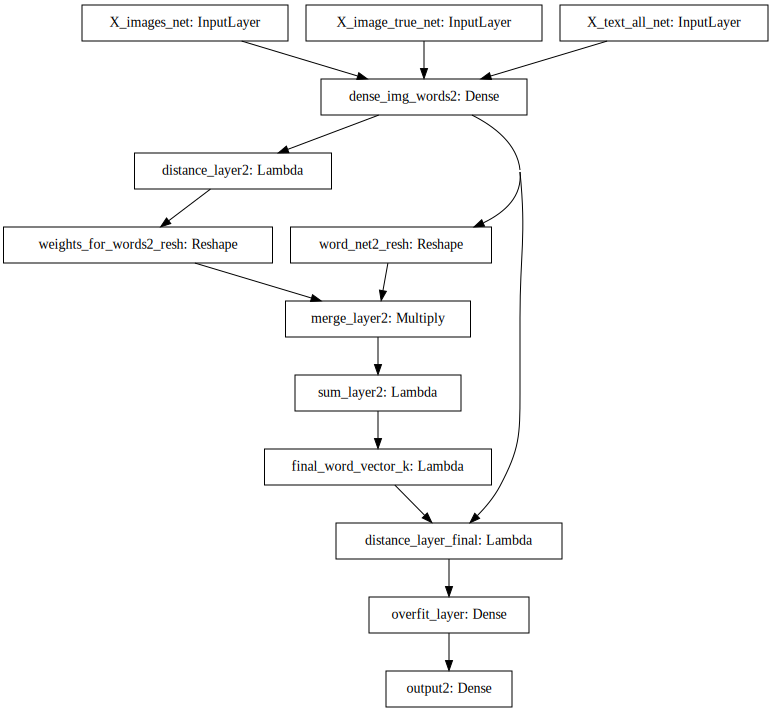

In [15]:
from keras.utils import plot_model
plot_model(model_hard, to_file='model_hard.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_hard).create(prog='dot', format='svg' ))


In [ ]:
path_coco_imgs = 'data_coco_flkr/coco_test_ims.npy'
images_coco = np.load(path_coco_imgs)
image_vectors_coco = tools.encode_images(model, images_coco)

In [ ]:
import keras
batch_size = 200
fun_train = generate_arrays_from_file(image_vectors_coco,words_vectors, num_samples = 50, k = 10, num_words = 998)
steps = 100
epochs = 2

tbCallBack = keras.callbacks.TensorBoard(log_dir='Graph', histogram_freq=0,  
          write_graph=True, write_images=True)
#tbCallback.set_model(tbCallBack)

model_hard.fit_generator(fun_train,steps, epochs, verbose=1,
                         shuffle = True, callbacks=[tbCallBack]) #validation_steps=fun_val,

In [ ]:
import tensorflow as tf
from tensorflow.python import debug as tf_debug
import keras
keras.backend.set_session(
    tf_debug.TensorBoardDebugWrapperSession(tf.Session(), "lichi.haze.yandex.net:6007"))

In [ ]:
%pylab inline
# чуть покрасивше картинки:
#pd.set_option('display.mpl_style', 'default')
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Ubuntu'
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
# чтобы был русский шрифт
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)


In [ ]:

# Размножаем вектор для multiply слоя
weights_for_words2_resh_1000 = Lambda(lambda x: K.repeat(x, 100), output_shape=(100, num_words),
                             name = 'weights_for_words2_resh_1000')(weights_for_words2)